In [1]:
%cd ..

import torch
from torch import nn
import torch.nn.functional as F
from torchvision.transforms import Compose
from torch.utils.data import DataLoader
from time import time

from models import ADTOF_FrameRNN, ADTOF_FrameAttention
from preprocess import compute_normalization, create_transform, invert_mel_spectrogram
from evaluate import compute_peaks, compute_predictions, f_measure, evaluate_model
from pathlib import Path

import matplotlib.pyplot as plt
import IPython

/Users/runarfosse/Library/Python/3.11/lib/python/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/Users/runarfosse/Desktop/OneDrive - University of Bergen/Master Thesis


## Load a model

In [2]:
# Create a path to the study directory
path = Path("study/Test").resolve()

# Load the training config
config = torch.load(path / "config.pt")

# And the model
model = ADTOF_FrameAttention(**config["parameters"])
state_dict = torch.load(path / "model.pt", map_location="cpu")
model.load_state_dict(state_dict)

# Create a transform model
#transforms = create_transform(mean=1.5236, std=1.3725, channels_last=True)
#transforms = create_transform(mean=0, std=1, channels_last=True)
#transforms = create_transform(mean=0.6647, std=0.5941, channels_last=True)
transforms = create_transform(**config["transforms"], channels_last=True)
print("ENST values:", compute_normalization(Path("data/ENST-drums-public.pt").resolve(), batch_size=4))
print("ADTOF values:", config["transforms"].values())

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


ENST values: (tensor([0.3270]), tensor([0.3853]))
ADTOF values: dict_values([tensor([0.7242]), tensor([0.5008])])


## Visualize model prediction on a datapoint

In [3]:
def plot_prediction(model: nn.Module, data: torch.Tensor, label: torch.Tensor, transforms: Compose) -> None:

    # Predict using the model
    with torch.no_grad():
        if transforms:
            data = transforms(data)
        activation = F.sigmoid(model(data))
        prediction = compute_peaks(activation).round()

    # And plot
    fig, ax = plt.subplots(3)

    ax[0].set_title("Data (400 frames, 84 bins, 1 channel)")
    ax[0].imshow(data.squeeze().T)
    ax[0].set_xlabel("Frames (hop size: 10ms)")
    ax[0].set_ylabel("Frequency bins")
    ax[0].invert_yaxis()

    ax[1].set_title("Target (400 frames, 5 classes)")
    ax[1].imshow(label.squeeze().T.round(), aspect=10, interpolation="nearest")
    ax[1].set_xlabel("Frames (hop size: 10ms)")
    ax[1].set_ylabel("Classes")
    ax[1].set_yticks([0, 1, 2, 3, 4], ("BD", "SD", "TT", "HH", "CY+RD"))
    ax[1].invert_yaxis()

    ax[2].set_title("Prediction (400 frames, 5 classes)")
    ax[2].imshow(prediction.squeeze().T, aspect=10, interpolation="nearest")
    ax[2].set_xlabel("Frames (hop size: 10ms)")
    ax[2].set_ylabel("Classes")
    ax[2].set_yticks([0, 1, 2, 3, 4], ("BD", "SD", "TT", "HH", "CY+RD"))
    ax[2].invert_yaxis()

    fig.tight_layout()
    plt.show()

In [68]:
# Load the validation dataset
#val_path = Path("data/ENST-drums-public.pt").resolve()
val_path = Path("data/adtof/adtof_yt_validation.pt").resolve()
val_loader = DataLoader(torch.load(val_path), shuffle=True, batch_size=1)

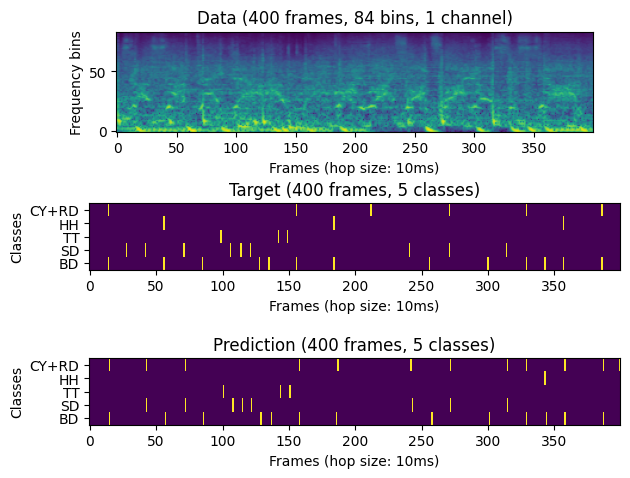

In [69]:
# Set the model to eval mode
model.eval()

# And plot a prediction
data, label = next(iter(val_loader))
plot_prediction(model, data, label, transforms)

In [6]:
data.squeeze(dim=(0, -1)).shape

torch.Size([400, 84])

In [70]:
spectrogram = data.squeeze(dim=(0, -1)).T
spectrogram = (torch.pow(torch.tensor(10), spectrogram) - 1) / 100
#spectrogram = (torch.exp(spectrogram) - 1) / 1000

pseudo_waveform = invert_mel_spectrogram(spectrogram, n_mels=84, f_min=20, f_max=20000, norm="slaney", mel_scale="htk", power=1)
IPython.display.Audio(pseudo_waveform.numpy(), rate=44100)

## Compute performance measure over different datasets

In [8]:
enst_loader = DataLoader(torch.load(Path("data/ENST-drums-public.pt").resolve()), batch_size=8)
enst_f1_micro, _, enst_f1_class = evaluate_model(model, test_loader=enst_loader, transforms=transforms, device="cpu")
print("ENST F1 micro: ", enst_f1_micro)
print("ENST F1 class: ", enst_f1_class)
#
#adtof_loader = DataLoader(torch.load(Path("data/adtof/adtof_yt_validation.pt").resolve()), batch_size=8)
#adtof_f1_micro, _, adtof_f1_class = evaluate_model(model, test_loader=adtof_loader, transforms=transforms, device="cpu")
#print("ADTOF F1 micro: ", adtof_f1_micro)
#print("ADTOF F1 class: ", adtof_f1_class)

Testing: Can use CUDA: False
ENST F1 micro:  tensor(0.8125)
ENST F1 class:  tensor([0.8932, 0.7928, 0.3803, 0.8211, 0.7952])
